In [0]:
import os, random
import numpy as np
import matplotlib.pyplot as plt
from imutils import paths
from sklearn.model_selection import train_test_split
from PIL import Image
import requests
import os

In [0]:
try:
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf

from tensorflow.keras import models, layers, optimizers, utils, datasets, preprocessing, regularizers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import resnet, vgg16, inception_v3

tf.random.set_seed(17)

In [2]:
!rm -rf cousteau
!git clone https://github.com/datawookie/cousteau.git
  
from cousteau.keras.plot import plot_history

Cloning into 'cousteau'...
remote: Enumerating objects: 18, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (12/12), done.
Unpacking objects: 100% (18/18), done.
remote: Total 18 (delta 6), reused 16 (delta 4), pack-reused 0


In [3]:
!rm -rf car-dataset # allows us to re-clone the dataset w/ updates and get the changes - if folder exists, clone does not work and we won't get anychanges
!git clone https://github.com/GerardWalsh/car-dataset.git

Cloning into 'car-dataset'...
remote: Enumerating objects: 572, done.
remote: Counting objects: 100% (572/572), done.
remote: Compressing objects: 100% (510/510), done.
remote: Total 572 (delta 94), reused 534 (delta 61), pack-reused 0
Receiving objects: 100% (572/572), 26.95 MiB | 38.18 MiB/s, done.
Resolving deltas: 100% (94/94), done.


In [0]:
image_paths = list(paths.list_images("car-dataset/train"))

images = []
labels = []

for path in image_paths:
  img = preprocessing.image.load_img(path, target_size=(224, 224))
  img = np.expand_dims(img, axis=0)
  
  images.append(img)

  label = path.split(os.path.sep)[-2]
  if label == "7_5":
    label = 0
  elif label == "7":
    label = 1
  elif label == '6':
    label = 2
  else: 
    label = 3
  labels.append(label)

In [7]:
from collections import Counter
Counter(labels).keys()

dict_keys([3, 2, 1, 0])

In [8]:
Counter(labels).values()

dict_values([60, 89, 83, 68])

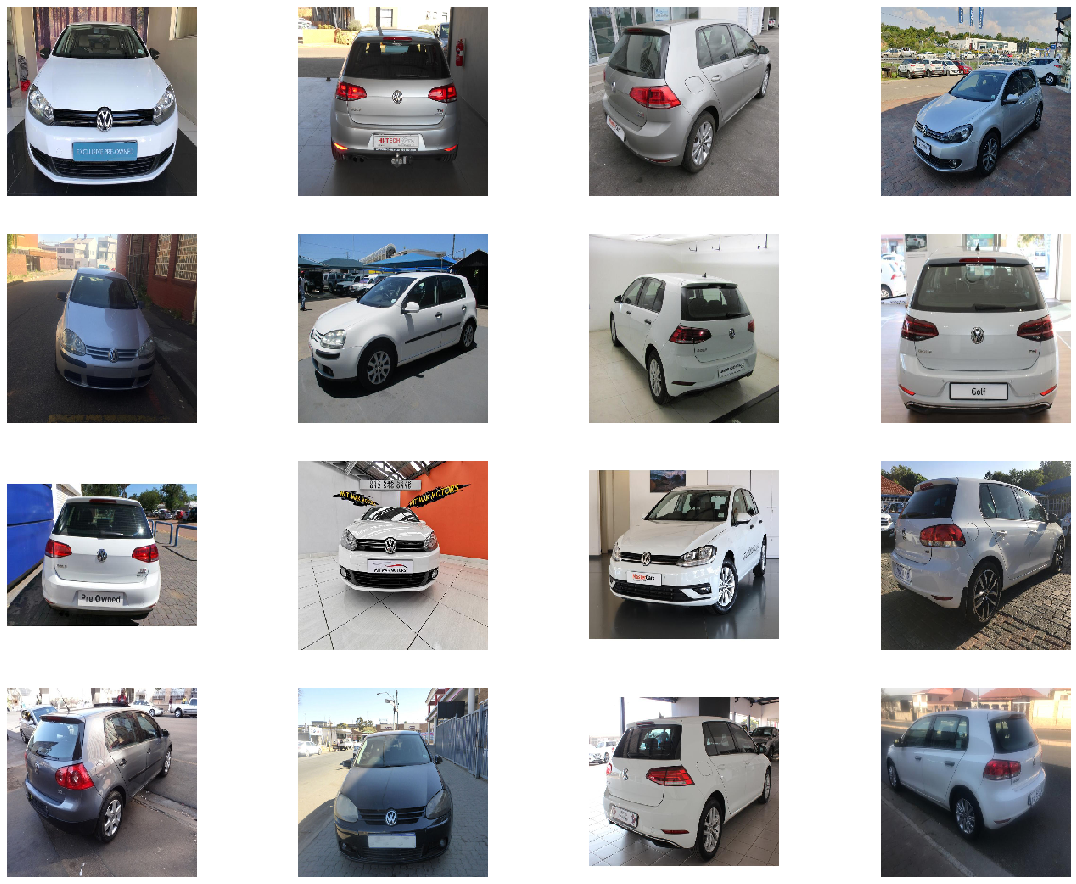

In [9]:
fig = plt.figure(figsize = (20, 16))

for i, img in zip(range(16), random.sample(images, 16)):
  fig.add_subplot(4, 4, i+1)
  plt.axis('off')
  plt.imshow(np.squeeze(img))

plt.show()

In [0]:
datagen = preprocessing.image.ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.25,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [0]:
def augment_image(image, replicates=4):
    images = [image]
    i = 1
    for batch in datagen.flow(image, batch_size=1):
        images.append(batch)
        i += 1
        if i >= replicates:
            break
    return images

In [0]:
REPLICATES = 4

In [0]:
images = [augment_image(image, REPLICATES) for image in images]

In [0]:
images = [image for sublist in images for image in sublist]

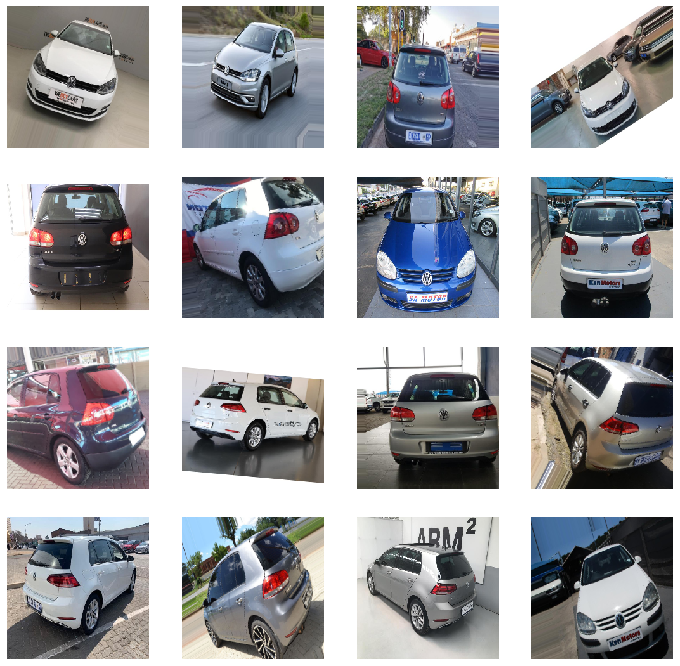

In [15]:
fig = plt.figure(figsize = (12, 12))

for i, img in zip(range(16), random.sample(images, 16)):
  fig.add_subplot(4, 4, i+1)
  plt.axis('off')
  # Transformations result in float32, so cast to uint8.
  plt.imshow(np.squeeze(img).astype('uint8'))

plt.show()

In [0]:
labez = [[label] * REPLICATES for label in labels]

In [0]:
labelz = np.array([label for sublist in labez for label in sublist])

In [18]:
print('Image count (after transform): {}'.format(len(images)), '\n', 'Label count (after transform): {}'.format(len(labelz)))

Image count (after transform): 1200 
 Label count (after transform): 1200


In [0]:
images = np.concatenate(images)

In [0]:
input_shape = images.shape[1:]

In [0]:
images = resnet.preprocess_input(images)

In [0]:
(X_train, X_test, y_train, y_test) = train_test_split(images, labelz, test_size=0.2, random_state=13)

In [23]:
from keras.utils import to_categorical

y_train = to_categorical(y_train, num_classes=4)
y_test = to_categorical(y_test, num_classes=4)

Using TensorFlow backend.


# VGG w/ weights initialised from Imagenet

In [0]:
BATCH_SIZE=32
EPOCHS = 25
LEARNING_RATE = 5e-5

In [0]:
base_model = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
base_model.trainable = True

In [147]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [0]:
def build_network(base):

  model = models.Sequential()

  model.add(base)
  model.add(layers.Flatten())
  model.add(layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
  model.add(layers.BatchNormalization())
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(4, activation='softmax'))

  return model

In [0]:
vgg = build_network(base_model)

In [0]:
vgg.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.Adam(lr=LEARNING_RATE),
    metrics=['accuracy']
)

In [151]:
history = vgg.fit(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=1,
    validation_split=0.2
)

Train on 768 samples, validate on 192 samples
Epoch 1/25
768/768 [==============================] - 12s 16ms/sample - loss: 2.2169 - accuracy: 0.3294 - val_loss: 4.2563 - val_accuracy: 0.3385
Epoch 2/25
768/768 [==============================] - 12s 15ms/sample - loss: 1.4377 - accuracy: 0.5482 - val_loss: 2.2362 - val_accuracy: 0.4427
Epoch 3/25
768/768 [==============================] - 12s 15ms/sample - loss: 1.0676 - accuracy: 0.7005 - val_loss: 1.3356 - val_accuracy: 0.6302
Epoch 4/25
768/768 [==============================] - 12s 15ms/sample - loss: 0.8042 - accuracy: 0.8125 - val_loss: 1.0967 - val_accuracy: 0.6667
Epoch 5/25
768/768 [==============================] - 12s 15ms/sample - loss: 0.6518 - accuracy: 0.8841 - val_loss: 0.7537 - val_accuracy: 0.8698
Epoch 6/25
768/768 [==============================] - 12s 15ms/sample - loss: 0.5590 - accuracy: 0.9310 - val_loss: 0.6564 - val_accuracy: 0.9062
Epoch 7/25
768/768 [==============================] - 11s 15ms/sample - loss: 

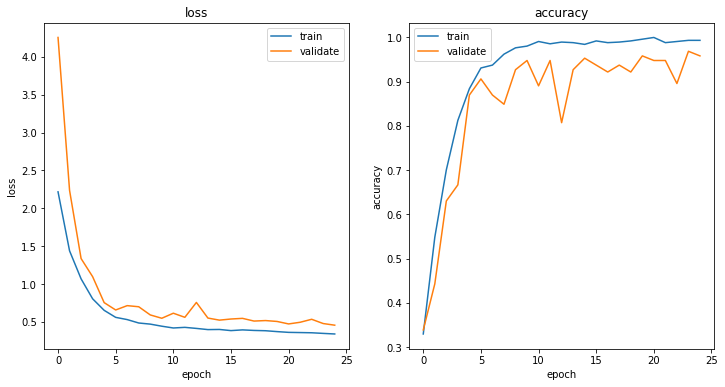

In [154]:
plot_history(history)

In [153]:
score = vgg.evaluate(X_test, y_test, verbose=0)
print("Test accuracy = {:.2f}%".format(score[1]*100),"\nTest loss     = {:.6f}".format(score[0]))

Test accuracy = 95.00% 
Test loss     = 0.503446


# Unseen data

## Helper functions

In [0]:
def store_image(img_url, class_type):

  filename = ''
  response = requests.get(img_url)

  if response.status_code == 200:
    directory = 'car-dataset/train/{}'.format(class_type)
    os.chdir(directory)
    filename = str(max(sorted([int(prefix.split('.')[0]) for prefix in os.listdir()])) + 1)

    with open('{}.jpg'.format(filename), 'wb') as f:
      f.write(response.content)

    os.chdir('../../..')

  return directory + '/{}.jpg'.format(filename)

In [0]:
def classify(img_url, class_type, **trained_model):
  
  filename = store_image(img_url, class_type)
  img = image.load_img(filename, target_size=(224, 224))

  plt.imshow(np.squeeze(img).astype('uint8'))

  img = image.img_to_array(img)
  img = resnet.preprocess_input(img)
  img = np.expand_dims(img, axis=0)

  for name, model in trained_model.items(): 
    golf = model.predict_classes(img)
    if (golf == 0):
      golf = '7.5'
    elif (golf == 1):
      golf = '7'
    elif (golf == 2):#se:
      golf = '6'
    else: 
      golf = 5
    print('Classifier:', name)
    print('Golf model:', golf, ', proba:', model.predict_proba(img), '\n')

## Golf 5

Classifier: vgg_model
Golf model: 5 , proba: [[0.02553972 0.12859868 0.03544654 0.8104151 ]] 



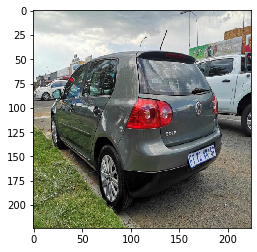

In [170]:
classify(
    'https://www.carmag.co.za/car-images/Gauteng/6091-648349_5/2007-Volkswagen-GOLF-5-GOLF-2.0-COMFORTLINE-5.jpeg',
    '5', vgg_model = vgg 
    )

Classifier: vgg_model
Golf model: 5 , proba: [[0.00560368 0.00731944 0.01254201 0.97453487]] 



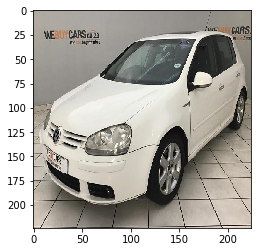

In [171]:
classify(
    'https://img.autotrader.co.za/5332243/Crop800x600',
    '5', vgg_model = vgg 
    )

Classifier: vgg_model
Golf model: 5 , proba: [[0.005607   0.00226686 0.06668811 0.92543805]] 



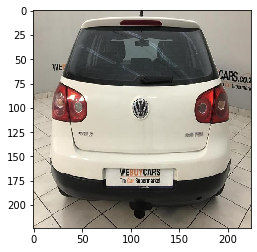

In [172]:
classify(
    'https://img.autotrader.co.za/5332244/Crop800x600',
    '5', vgg_model = vgg 
    )

Classifier: vgg_model
Golf model: 5 , proba: [[0.00832774 0.00346882 0.1182393  0.8699641 ]] 



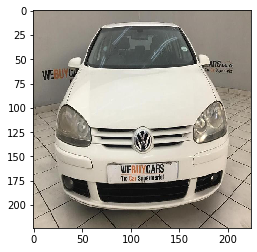

In [173]:
classify(
    'https://img.autotrader.co.za/5332246/Crop800x600',
    '5', vgg_model = vgg 
    )

Classifier: vgg_model
Golf model: 5 , proba: [[0.06733349 0.01131338 0.0290012  0.89235187]] 



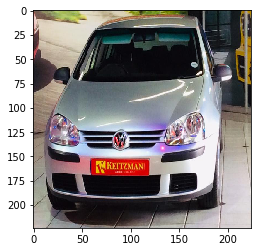

In [174]:
classify(
    'https://img.autotrader.co.za/5243443/Crop800x600',
    '5', vgg_model = vgg 
    )

Classifier: vgg_model
Golf model: 5 , proba: [[0.01096439 0.05779724 0.08626557 0.8449727 ]] 



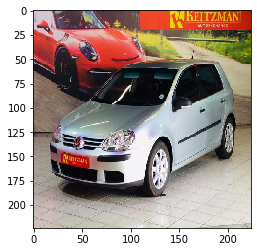

In [175]:
classify(
    'https://img.autotrader.co.za/5243442/Crop800x600',
    '5', vgg_model = vgg 
    )

## Golf 6

Classifier: vgg_model
Golf model: 6 , proba: [[0.0051624  0.00099775 0.9876473  0.00619258]] 



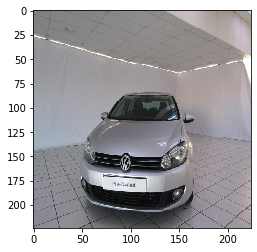

In [157]:
classify(
    'https://img.autotrader.co.za/3760195/Crop800x600',
    '6', vgg_model = vgg 
    )

Classifier: vgg_model
Golf model: 6 , proba: [[0.00799283 0.00416018 0.97289824 0.01494871]] 



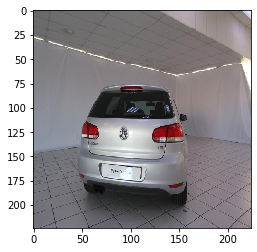

In [158]:
classify(
    'https://img.autotrader.co.za/3760198/Crop800x600',
    '6', vgg_model = vgg
)

Classifier: vgg_model
Golf model: 5 , proba: [[0.21056339 0.19783516 0.26849127 0.32311016]] 



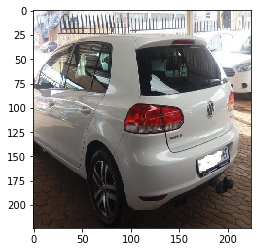

In [159]:
classify(
    'https://img-ik.cars.co.za/carsimages/tr:n-stock_med/5416351_5.jpg?v=1868034972',
    '6', vgg_model = vgg
)

Classifier: vgg_model
Golf model: 6 , proba: [[0.01275877 0.00275824 0.9692202  0.01526276]] 



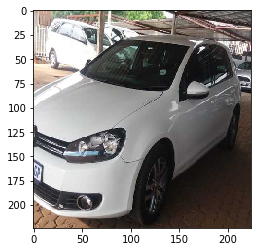

In [160]:
classify(
    'https://img-ik.cars.co.za/carsimages/tr:n-stock_med/5416351.jpg?v=1868034972',
    '6', vgg_model = vgg
)

Classifier: vgg_model
Golf model: 6 , proba: [[0.17997223 0.01207888 0.7838442  0.02410473]] 



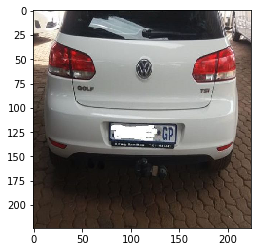

In [161]:
classify(
    'https://img-ik.cars.co.za/carsimages/tr:n-stock_med/5416351_6.jpg?v=1868034972',
    '6', vgg_model = vgg
)

Classifier: vgg_model
Golf model: 6 , proba: [[0.00891604 0.02759684 0.94699067 0.01649651]] 



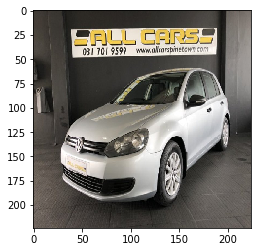

In [162]:
classify(
    'https://img-ik.cars.co.za/carsimages/tr:n-stock_large/5532964.jpg?v=125421204',
    '6', vgg_model = vgg
)

Classifier: vgg_model
Golf model: 6 , proba: [[0.15110284 0.00801426 0.7743112  0.06657174]] 



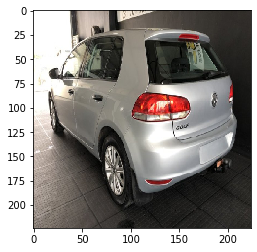

In [163]:
classify(
    'https://img-ik.cars.co.za/carsimages/tr:n-stock_large/5532964_3.jpg?v=125421204',
    '6', vgg_model = vgg
)

Classifier: vgg_model
Golf model: 6 , proba: [[3.0423636e-03 7.9161191e-04 9.7542113e-01 2.0744951e-02]] 



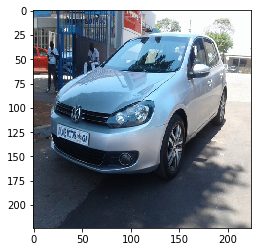

In [164]:
classify(
    'https://img-ik.cars.co.za/carsimages/tr:n-stock_med/5499518.jpg?v=2265708515',
    '6', vgg_model = vgg
)

Classifier: vgg_model
Golf model: 6 , proba: [[1.0662184e-02 2.2394631e-04 8.6391377e-01 1.2520009e-01]] 



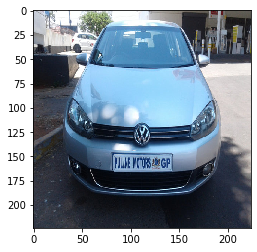

In [165]:
classify(
    'https://img-ik.cars.co.za/carsimages/tr:n-stock_med/5499518_2.jpg?v=2265708515',
    '6', vgg_model = vgg
)

Classifier: vgg_model
Golf model: 6 , proba: [[0.01057636 0.00411312 0.9360758  0.04923472]] 



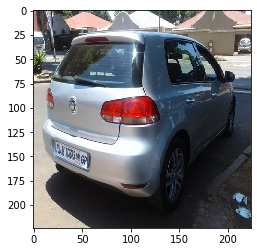

In [166]:
classify(
    'https://img-ik.cars.co.za/carsimages/tr:n-stock_med/5499518_8.jpg?v=2265708515',
    '6', vgg_model = vgg
)

Classifier: vgg_model
Golf model: 6 , proba: [[0.00684461 0.14008017 0.7065266  0.14654858]] 



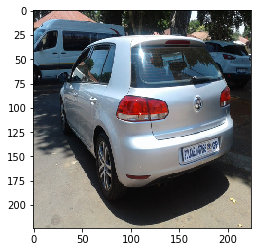

In [167]:
classify(
    'https://img-ik.cars.co.za/carsimages/tr:n-stock_med/5499518_7.jpg?v=2265708515',
    '6', vgg_model = vgg
)

Classifier: vgg_model
Golf model: 6 , proba: [[0.00409437 0.0393041  0.89196396 0.06463762]] 



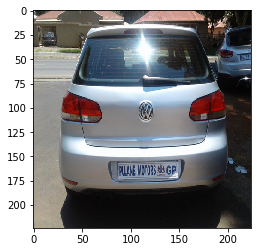

In [168]:
classify(
    'https://img-ik.cars.co.za/carsimages/tr:n-stock_med/5499518_6.jpg?v=2265708515',
    '6', vgg_model = vgg
)

Classifier: vgg_model
Golf model: 6 , proba: [[0.02250816 0.01634282 0.8931389  0.06801012]] 



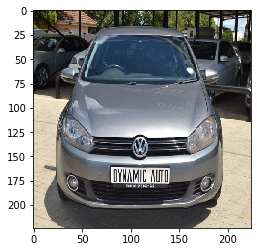

In [169]:
classify(
    'https://img-ik.cars.co.za/carsimages/tr:n-stock_med/5530306_2.jpg?v=4074465811',
    '6', vgg_model = vgg
)

## Golf 7


Classifier: vgg_model
Golf model: 7 , proba: [[0.19319153 0.28297716 0.25057968 0.27325165]] 



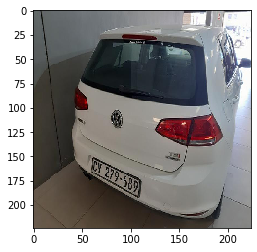

In [176]:
classify(
    'https://img.autotrader.co.za/4873898/Crop800x600',
    '7', vgg_model = vgg
)

Classifier: vgg_model
Golf model: 7 , proba: [[0.3647648  0.53148574 0.06091982 0.04282964]] 



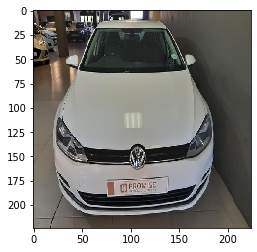

In [177]:
classify(
         'https://img.autotrader.co.za/4873896/Crop800x600',
         '7', vgg_model = vgg
         )

Classifier: vgg_model
Golf model: 7.5 , proba: [[0.34612694 0.27826613 0.25654337 0.11906358]] 



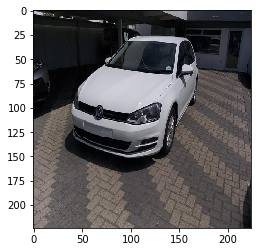

In [178]:
classify(
         'https://img.autotrader.co.za/5248234/Crop800x600',
         '7', vgg_model = vgg
         )


Classifier: vgg_model
Golf model: 7 , proba: [[0.04172217 0.7730111  0.00966735 0.17559938]] 



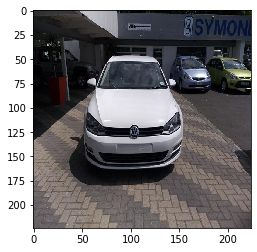

In [179]:
classify(
         'https://img.autotrader.co.za/5248233/Crop800x600',
         '7', vgg_model = vgg
         )

## Golf 7.5

Classifier: vgg_model
Golf model: 7 , proba: [[0.12688886 0.7327433  0.02491426 0.11545353]] 



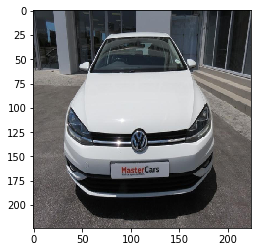

In [180]:
classify(
    'https://img.autotrader.co.za/4971489/Crop800x600',
    '7_5', vgg_model = vgg
)

Classifier: vgg_model
Golf model: 7 , proba: [[0.10927939 0.8066816  0.03463072 0.04940842]] 



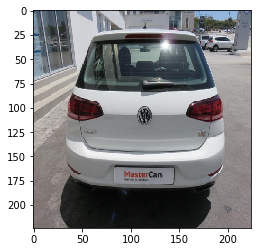

In [181]:
classify(
    'https://img.autotrader.co.za/4971493/Crop800x600',
    '7_5', vgg_model = vgg
)

Classifier: vgg_model
Golf model: 7.5 , proba: [[0.6111892  0.17109607 0.09825706 0.11945773]] 



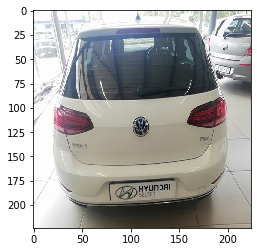

In [182]:
classify(
    'https://img-ik.cars.co.za/carsimages/tr:n-stock_med/5570873_6.jpg?v=317154964',
    '7_5', vgg_model = vgg
)

Classifier: vgg_model
Golf model: 7.5 , proba: [[0.8722728  0.01292105 0.05953469 0.05527148]] 



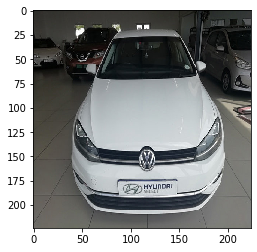

In [183]:
classify(
    'https://img-ik.cars.co.za/carsimages/tr:n-stock_med/5570873_3.jpg?v=317154964',
    '7_5', vgg_model = vgg
)

Classifier: vgg_model
Golf model: 7.5 , proba: [[0.68229026 0.14901182 0.00478707 0.16391085]] 



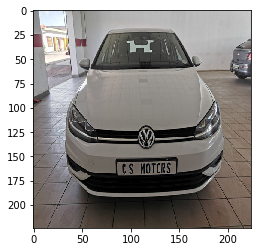

In [184]:
classify(
    'https://img-ik.cars.co.za/carsimages/tr:n-stock_med/5428529_2.jpg?v=158700226',
    '7_5', vgg_model = vgg
)

Classifier: vgg_model
Golf model: 7.5 , proba: [[0.65249604 0.08766636 0.03087929 0.2289583 ]] 



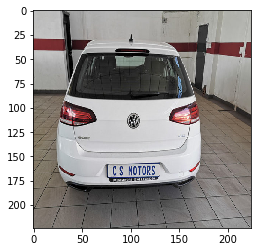

In [185]:
classify(
    'https://img-ik.cars.co.za/carsimages/tr:n-stock_med/5428529_7.jpg?v=158700226',
    '7_5', vgg_model = vgg
)

In [0]:
# 1. Change classify function to accept multiple models
# 2. Build simple network to count side/front/rear shots of each class
# 3. Investigate network ensemble